LOADING AND PREPROCESSING DATA

Dataset shape: (1000, 21)

First few rows:
   Creditability  Account_Balance  Duration_of_Credit_monthly  \
0              1                1                          18   
1              1                1                           9   
2              1                2                          12   
3              1                1                          12   
4              1                1                          12   

   Payment_Status_of_Previous_Credit  Purpose  Credit_Amount  \
0                                  4        2           1049   
1                                  4        0           2799   
2                                  2        9            841   
3                                  4        0           2122   
4                                  4        0           2171   

   Value_Savings_Stocks  Length_of_current_employment  Instalment_per_cent  \
0                     1                             2                  

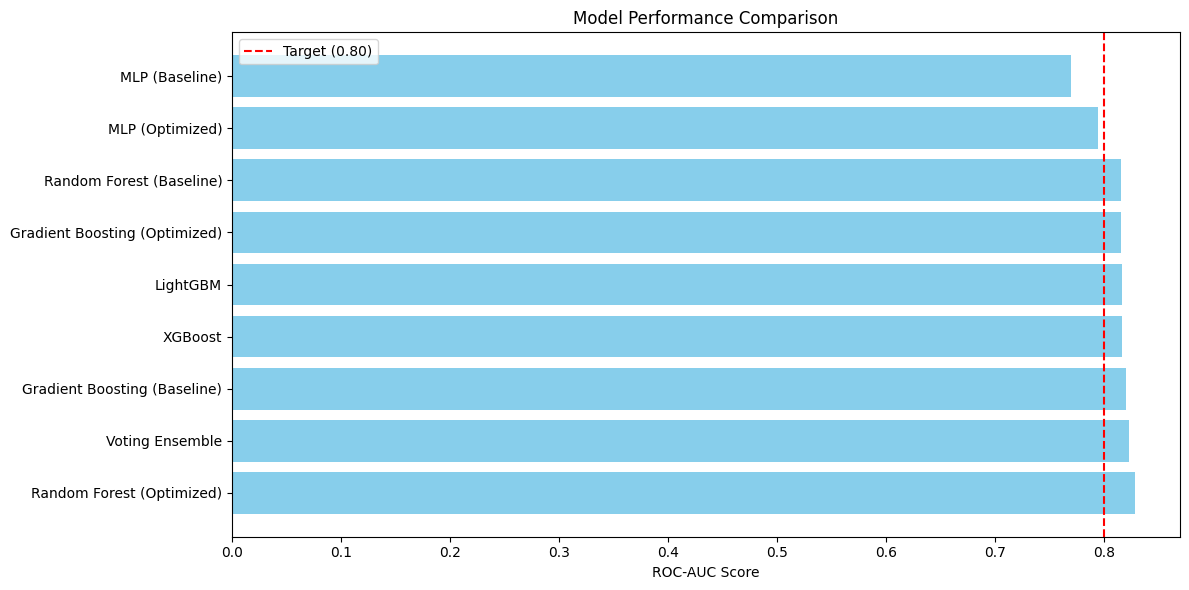


✅ Analysis complete!


In [5]:
import warnings
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, classification_report
import xgboost as xgb
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore') # Ignore warnings

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ============================================
# 1. DATA LOADING AND PREPROCESSING
# ============================================

print("=" * 60)
print("LOADING AND PREPROCESSING DATA")
print("=" * 60)

# Load data
data = pd.read_csv('/content/german.csv', sep=';')
print(f"\nDataset shape: {data.shape}")
print(f"\nFirst few rows:\n{data.head()}")

# Separate features and target
X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values

print(f"\nClass distribution:")
print(pd.Series(y).value_counts())
print(f"Class balance: {pd.Series(y).value_counts(normalize=True)}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Scale features (important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ============================================
# 2. BASELINE MODELS
# ============================================

print("\n" + "=" * 60)
print("BASELINE MODELS (Original Parameters)")
print("=" * 60)

# Random Forest Baseline
rf_baseline = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
rf_baseline.fit(X_train, y_train)
rf_pred = rf_baseline.predict(X_test)
rf_proba = rf_baseline.predict_proba(X_test)[:, 1]

print("\nRandom Forest Baseline:")
print(f"ROC-AUC: {roc_auc_score(y_test, rf_proba):.4f}")
print(f"Accuracy: {accuracy_score(y_test, rf_pred):.4f}")

# Gradient Boosting Baseline
gb_baseline = GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE)
gb_baseline.fit(X_train, y_train)
gb_pred = gb_baseline.predict(X_test)
gb_proba = gb_baseline.predict_proba(X_test)[:, 1]

print("\nGradient Boosting Baseline:")
print(f"ROC-AUC: {roc_auc_score(y_test, gb_proba):.4f}")
print(f"Accuracy: {accuracy_score(y_test, gb_pred):.4f}")

# MLP Baseline
mlp_baseline = MLPClassifier(hidden_layer_sizes=(30,), max_iter=500, random_state=RANDOM_STATE)
mlp_baseline.fit(X_train_scaled, y_train)
mlp_pred = mlp_baseline.predict(X_test_scaled)
mlp_proba = mlp_baseline.predict_proba(X_test_scaled)[:, 1]

print("\nMLP Baseline:")
print(f"ROC-AUC: {roc_auc_score(y_test, mlp_proba):.4f}")
print(f"Accuracy: {accuracy_score(y_test, mlp_pred):.4f}")

# ============================================
# 3. OPTIMIZED MODELS
# ============================================

print("\n" + "=" * 60)
print("HYPERPARAMETER OPTIMIZATION")
print("=" * 60)

# -------- Random Forest Optimization --------
print("\n1. Optimizing Random Forest...")
rf_params = {
    'n_estimators': [200, 300],
    'max_depth': [10, 15],
    'min_samples_split': [5],
    'min_samples_leaf': [2],
    'max_features': ['sqrt'],
    'class_weight': [None]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE),
    rf_params,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_

print(f"Best RF params: {rf_grid.best_params_}")
rf_best_proba = rf_best.predict_proba(X_test)[:, 1]
print(f"Best RF ROC-AUC: {roc_auc_score(y_test, rf_best_proba):.4f}")

# -------- Gradient Boosting Optimization --------
print("\n2. Optimizing Gradient Boosting...")
gb_params = {
    'n_estimators': [200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [5],
    'min_samples_leaf': [2],
    'subsample': [0.8]
}

gb_grid = GridSearchCV(
    GradientBoostingClassifier(random_state=RANDOM_STATE),
    gb_params,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
gb_grid.fit(X_train, y_train)
gb_best = gb_grid.best_estimator_

print(f"Best GB params: {gb_grid.best_params_}")
gb_best_proba = gb_best.predict_proba(X_test)[:, 1]
print(f"Best GB ROC-AUC: {roc_auc_score(y_test, gb_best_proba):.4f}")

# -------- XGBoost (Advanced Boosting) --------
print("\n3. Training XGBoost...")
xgb_params = {
    'n_estimators': [200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'min_child_weight': [1],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'scale_pos_weight': [1]
}

xgb_grid = GridSearchCV(
    xgb.XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss'),
    xgb_params,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
xgb_grid.fit(X_train, y_train)
xgb_best = xgb_grid.best_estimator_

print(f"Best XGBoost params: {xgb_grid.best_params_}")
xgb_best_proba = xgb_best.predict_proba(X_test)[:, 1]
print(f"Best XGBoost ROC-AUC: {roc_auc_score(y_test, xgb_best_proba):.4f}")

# -------- LightGBM --------
print("\n4. Training LightGBM...")
lgbm_params = {
    'n_estimators': [200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'num_leaves': [31],
    'min_child_samples': [20],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

lgbm_grid = GridSearchCV(
    LGBMClassifier(random_state=RANDOM_STATE, verbose=-1),
    lgbm_params,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
lgbm_grid.fit(X_train, y_train)
lgbm_best = lgbm_grid.best_estimator_

print(f"Best LightGBM params: {lgbm_grid.best_params_}")
lgbm_best_proba = lgbm_best.predict_proba(X_test)[:, 1]
print(f"Best LightGBM ROC-AUC: {roc_auc_score(y_test, lgbm_best_proba):.4f}")

# -------- Neural Network Optimization --------
print("\n5. Optimizing Neural Network...")
mlp_params = {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation': ['relu'],
    'alpha': [0.001, 0.01],
    'learning_rate': ['adaptive'],
    'max_iter': [500]
}

mlp_grid = GridSearchCV(
    MLPClassifier(random_state=RANDOM_STATE, early_stopping=True),
    mlp_params,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
mlp_grid.fit(X_train_scaled, y_train)
mlp_best = mlp_grid.best_estimator_

print(f"Best MLP params: {mlp_grid.best_params_}")
mlp_best_proba = mlp_best.predict_proba(X_test_scaled)[:, 1]
print(f"Best MLP ROC-AUC: {roc_auc_score(y_test, mlp_best_proba):.4f}")

# ============================================
# 4. ENSEMBLE (VOTING)
# ============================================

print("\n" + "=" * 60)
print("ENSEMBLE MODEL (VOTING)")
print("=" * 60)

# Create voting ensemble with best models
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_best),
        ('gb', gb_best),
        ('xgb', xgb_best),
        ('lgbm', lgbm_best)
    ],
    voting='soft',
    weights=[1, 1, 2, 2]  # Give more weight to XGBoost and LightGBM
)

voting_clf.fit(X_train, y_train)
voting_proba = voting_clf.predict_proba(X_test)[:, 1]

print(f"\nVoting Ensemble ROC-AUC: {roc_auc_score(y_test, voting_proba):.4f}")

# ============================================
# 5. FINAL RESULTS COMPARISON
# ============================================

print("\n" + "=" * 60)
print("FINAL RESULTS COMPARISON")
print("=" * 60)

results = {
    'Model': [
        'Random Forest (Baseline)',
        'Gradient Boosting (Baseline)',
        'MLP (Baseline)',
        'Random Forest (Optimized)',
        'Gradient Boosting (Optimized)',
        'XGBoost',
        'LightGBM',
        'MLP (Optimized)',
        'Voting Ensemble'
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, rf_proba),
        roc_auc_score(y_test, gb_proba),
        roc_auc_score(y_test, mlp_proba),
        roc_auc_score(y_test, rf_best_proba),
        roc_auc_score(y_test, gb_best_proba),
        roc_auc_score(y_test, xgb_best_proba),
        roc_auc_score(y_test, lgbm_best_proba),
        roc_auc_score(y_test, mlp_best_proba),
        roc_auc_score(y_test, voting_proba)
    ]
}

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('ROC-AUC', ascending=False)
print("\n", results_df.to_string(index=False))

# Find best model
best_idx = results_df['ROC-AUC'].idxmax()
best_model_name = results_df.loc[best_idx, 'Model']
best_auc = results_df.loc[best_idx, 'ROC-AUC']

print(f"\n{'='*60}")
print(f"BEST MODEL: {best_model_name}")
print(f"BEST ROC-AUC: {best_auc:.4f}")
print(f"{'='*60}")

# Grading
if best_auc > 0.80:
    print("\n🎉 EXCELLENT! Score: 10/10 points")
elif best_auc > 0.79:
    print("\n✅ Great! Score: 8/10 points")
elif best_auc > 0.78:
    print("\n👍 Good! Score: 6/10 points")
elif best_auc > 0.77:
    print("\n👌 Okay! Score: 4/10 points")
elif best_auc > 0.76:
    print("\n⚠️ Minimal pass. Score: 2/10 points")
else:
    print("\n❌ Below threshold. Score: 0/10 points")

# ============================================
# 6. VISUALIZATION
# ============================================

print("\n" + "=" * 60)
print("VISUALIZATIONS")
print("=" * 60)

# Plot model comparison
plt.figure(figsize=(12, 6))
plt.barh(results_df['Model'], results_df['ROC-AUC'], color='skyblue')
plt.xlabel('ROC-AUC Score')
plt.title('Model Performance Comparison')
plt.axvline(x=0.80, color='r', linestyle='--', label='Target (0.80)')
plt.legend()
plt.tight_layout()
plt.show()

# Feature importance (for best tree-based model)
if 'XGBoost' in best_model_name or 'LightGBM' in best_model_name:
    plt.figure(figsize=(10, 8))
    if 'XGBoost' in best_model_name:
        feat_imp = xgb_best.feature_importances_
    else:
        feat_imp = lgbm_best.feature_importances_

    indices = np.argsort(feat_imp)[-15:]  # Top 15 features
    plt.barh(range(len(indices)), feat_imp[indices])
    plt.yticks(range(len(indices)), [f'Feature {i}' for i in indices])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 15 Feature Importances - {best_model_name}')

    plt.tight_layout()
    plt.show()

print("\n✅ Analysis complete!")